In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lokanadam_retinal_layer_segmentation_path = kagglehub.dataset_download('lokanadam/retinal-layer-segmentation')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_cropped_labeledimages.npy
/kaggle/input/retinal-layer-segmentation/Images_npy_files/weighted_cropped_images.npy
/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_labeledimages.npy
/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_images.npy
/kaggle/input/retinal-layer-segmentation/Images_npy_files/weighted_images.npy
/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_cropped_images.npy


# Segnet

In [ ]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load images and masks
images = np.load(r"/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_images.npy")  # Shape: (num_samples, height, width)
masks = np.load(r"/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_labeledimages.npy")  # Shape: (num_samples, height, width)

# Normalize images to [0, 1] and convert to float32
images = np.clip(images, 0, 255).astype(np.float32) / 255.0

# Resize images to the target shape (256, 256)
def resize_images(images, target_size=(256, 256)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Resize the loaded images
images_resized = resize_images(images)

# Resize masks (if needed) to ensure they are the same size as images
def resize_masks(masks, target_size=(256, 256)):
    resized_masks = []
    for mask in masks:
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_masks.append(resized_mask)
    return np.array(resized_masks)

masks_resized = resize_masks(masks)

# Convert masks to one-hot encoding
num_classes = 8  # Adjust based on your dataset
masks_categorical = tf.keras.utils.to_categorical(masks_resized, num_classes=num_classes)

# Ensure images are in shape (num_samples, height, width, 1)
images_resized = np.expand_dims(images_resized, axis=-1)  # Now shape is (num_samples, height, width, 1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_resized, masks_categorical, test_size=0.2, random_state=42)

# Define the SegNet model
def segnet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    p5 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(p5)
    u6 = layers.concatenate([u6, c5])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c4])
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c3])
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c2])
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c9)

    u10 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c9)
    u10 = layers.concatenate([u10, c1])
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u10)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c10)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c10)  # Softmax for multi-class

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Dice and Jaccard coefficients
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())

# Custom loss function
def customized_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_coef(y_true, y_pred))

# Initialize and compile the SegNet model
input_shape = (256, 256, 1)  # Grayscale input shape
model = segnet_model(input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=customized_loss,
              metrics=['accuracy', dice_coef, jaccard_coef])

# Callbacks for training
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=6, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=50,
                    callbacks=[lr_reducer, csv_logger, model_checkpoint, tensorboard])



Epoch 1/50


I0000 00:00:1729615713.510312      98 service.cc:145] XLA service 0x7b74280019f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729615713.510367      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729615713.510371      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-22 16:49:45.864336: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-22 16:49:45.892980: E external/local

6/6 ━━━━━━━━━━━━━━━━━━━━ 239s 21s/step - accuracy: 0.4220 - dice_coef: 0.1786 - jaccard_coef: 0.1039 - loss: 2.7098 - val_accuracy: 0.6078 - val_dice_coef: 0.1407 - val_jaccard_coef: 0.0757 - val_loss: 2.4002 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5658 - dice_coef: 0.1802 - jaccard_coef: 0.1049 - loss: 4.2061 - val_accuracy: 0.6078 - val_dice_coef: 0.1380 - val_jaccard_coef: 0.0741 - val_loss: 2.4167 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5739 - dice_coef: 0.1362 - jaccard_coef: 0.0731 - loss: 2.4303 - val_accuracy: 0.6078 - val_dice_coef: 0.1351 - val_jaccard_coef: 0.0725 - val_loss: 2.4367 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5732 - dice_coef: 0.1353 - jaccard_coef: 0.0725 - loss: 2.4368 - val_accuracy: 0.6078 - val_dice_coef: 0.1387 - val_jaccard_coef: 0.0745 - val_loss: 2.4112 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/s

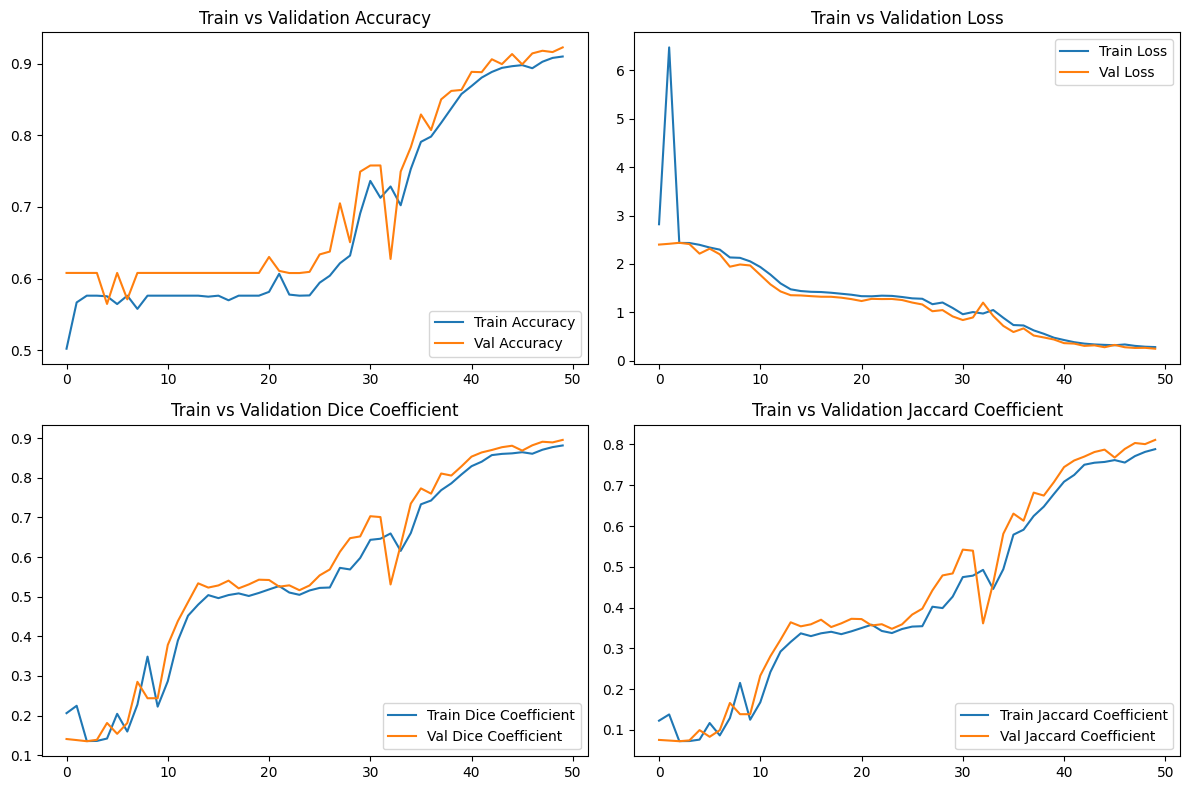

In [ ]:
# Plotting training history

def plot_training_history(history):
    # Get the history data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']
    jaccard = history.history['jaccard_coef']
    val_jaccard = history.history['val_jaccard_coef']
    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Train vs Validation Accuracy')

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train vs Validation Loss')

    # Plot Dice Coefficient
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, dice, label='Train Dice Coefficient')
    plt.plot(epochs_range, val_dice, label='Val Dice Coefficient')
    plt.legend(loc='lower right')
    plt.title('Train vs Validation Dice Coefficient')

    # Plot Jaccard Coefficient
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, jaccard, label='Train Jaccard Coefficient')
    plt.plot(epochs_range, val_jaccard, label='Val Jaccard Coefficient')
    plt.legend(loc='lower right')
    plt.title('Train vs Validation Jaccard Coefficient')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9222 - dice_coef: 0.8944 - jaccard_coef: 0.8091 - loss: 0.2499
Validation Loss: 0.24770651757717133, Validation Accuracy: 0.9226389527320862, Validation Dice Coefficient: 0.8957490921020508, Validation Jaccard Coefficient: 0.8112053871154785
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


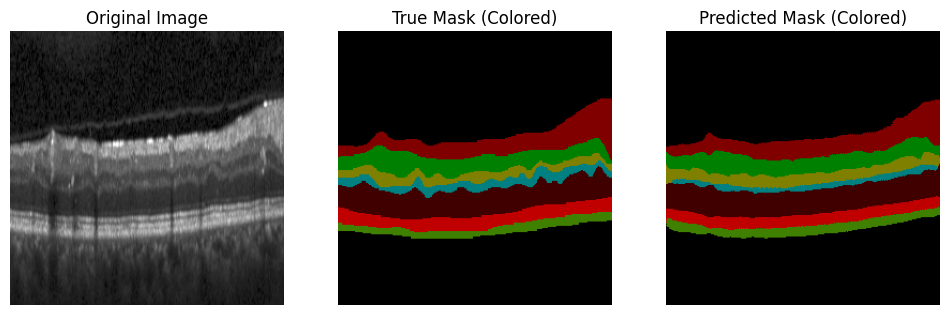

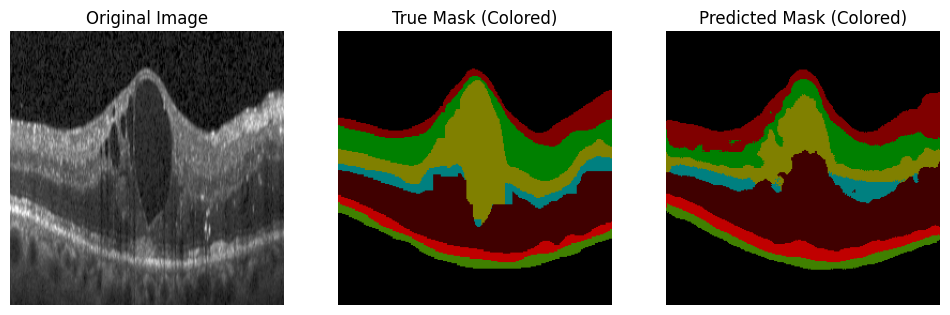

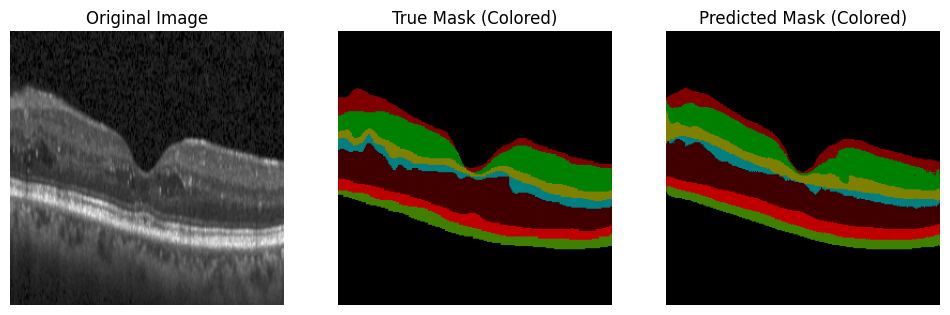

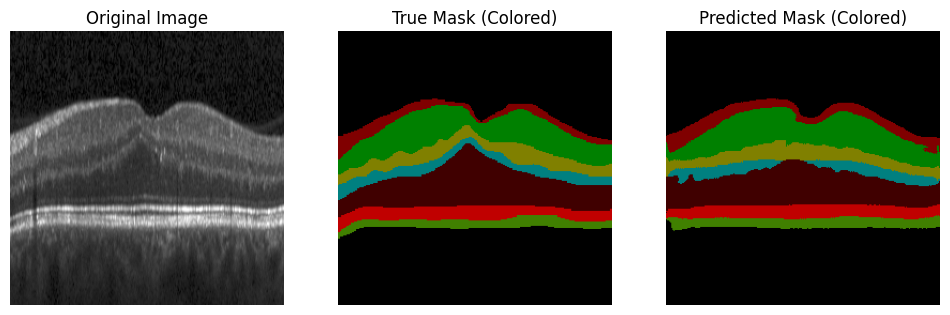

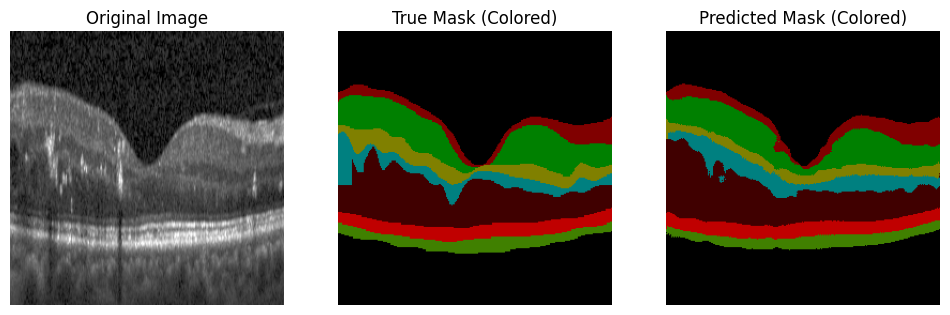

Model architecture and weights saved successfully.


In [ ]:
# Evaluate model performance on the validation set
val_loss, val_accuracy, val_dice, val_jaccard = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Dice Coefficient: {val_dice}, Validation Jaccard Coefficient: {val_jaccard}')

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert predictions to class labels

# Same color map for actual and predicted labels
color_map = {
    0: [0, 0, 0],        # Background
    1: [128, 0, 0],      # Class 1
    2: [0, 128, 0],      # Class 2
    3: [128, 128, 0],    # Class 3
    4: [0, 128, 128],    # Class 4
    5: [64, 0, 0],       # Class 5
    6: [192, 0, 0],      # Class 6
    7: [64, 128, 0]      # Class 7
}

# Create colored label image from predicted labels
def create_colored_label_image(output):
    colored_image = np.zeros((output.shape[0], output.shape[1], 3), dtype=np.uint8)  # Initialize colored image
    for j in range(output.shape[0]):
        for k in range(output.shape[1]):
            colored_image[j, k] = color_map[output[j][k]]
    return colored_image

# Generate colored label images for actual and predicted masks
colored_actual_labels = [create_colored_label_image(np.argmax(y_val[i], axis=-1)) for i in range(5)]
colored_predicted_labels = [create_colored_label_image(y_pred_classes[i]) for i in range(5)]

# Visualize results for the first 5 samples
def plot_results(index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(X_val[index].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask (Colored)')
    plt.imshow(colored_actual_labels[index])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask (Colored)')
    plt.imshow(colored_predicted_labels[index])
    plt.axis('off')

    plt.show()

# Visualize results for the first 5 samples
for i in range(5):
    plot_results(i)

# Save the model architecture to a .keras file
model.save("segnet_model.keras", save_format='keras')

print("Model architecture and weights saved successfully.")


# UNET

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load images and masks
images = np.load(r"/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_images.npy")
masks = np.load(r"/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_labeledimages.npy")

# Normalize images to [0, 1] and convert to float32
images = np.clip(images, 0, 255).astype(np.float32) / 255.0

# Convert grayscale images to RGB
def convert_to_rgb(images):
    return np.stack((images,) * 3, axis=-1)  # Repeat the single channel to create 3 channels

images_rgb = convert_to_rgb(images)

# Resize images and masks
def resize_images(images, target_size=(256, 256)):
    resized_images = []
    for img in images:
        if img.ndim == 2:  # Convert grayscale to RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

def resize_masks(masks, target_size=(256, 256)):
    resized_masks = []
    for mask in masks:
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_masks.append(resized_mask)
    return np.array(resized_masks)

images_resized = resize_images(images_rgb)
masks_resized = resize_masks(masks)

# Convert masks to one-hot encoding (assuming masks have integer labels)
num_classes = 8  # Change this according to your dataset
masks_categorical = tf.keras.utils.to_categorical(masks_resized, num_classes=num_classes)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_resized, masks_categorical, test_size=0.2, random_state=42)

# Define U-Net model
def unet_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # Softmax for multi-class

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Dice Coefficient
smooth = 1e-6

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Jaccard Index
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (total + smooth)

# Custom loss function
def customized_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + 0.5 * dice_coef_loss(y_true, y_pred)

# Initialize and compile the U-Net model
input_shape = (256, 256, 3)
model = unet_model(input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=customized_loss,
              metrics=['accuracy', dice_coef, jaccard_index])  # Add Jaccard index as a metric

# Callbacks for training
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=6, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

# Train the model
history1=model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=32,
          epochs=50,
          callbacks=[lr_reducer, csv_logger, model_checkpoint, tensorboard])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5429 - dice_coef: 0.1862 - jaccard_index: 0.1099 - loss: 2.5659 - val_accuracy: 0.6078 - val_dice_coef: 0.1411 - val_jaccard_index: 0.0759 - val_loss: 1.8987 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5722 - dice_coef: 0.1478 - jaccard_index: 0.0804 - loss: 1.9258 - val_accuracy: 0.6078 - val_dice_coef: 0.1422 - val_jaccard_index: 0.0765 - val_loss: 1.8889 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5790 - dice_coef: 0.1395 - jaccard_index: 0.0750 - loss: 1.9081 - val_accuracy: 0.6078 - val_dice_coef: 0.1449 - val_jaccard_index: 0.0781 - val_loss: 1.8697 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5688 - dice_coef: 0.1528 - jaccard_index: 0.0828 - loss: 1.8365 - val_accuracy: 0.6078 - val_dice_coef: 0.2301 - val_jaccard_index: 0.1300 - val_loss: 1.5881 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━

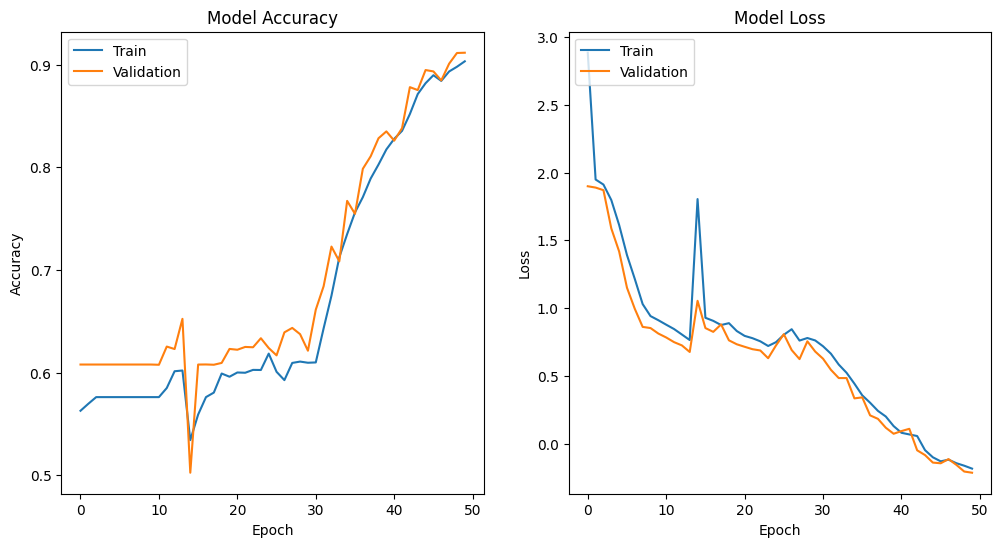

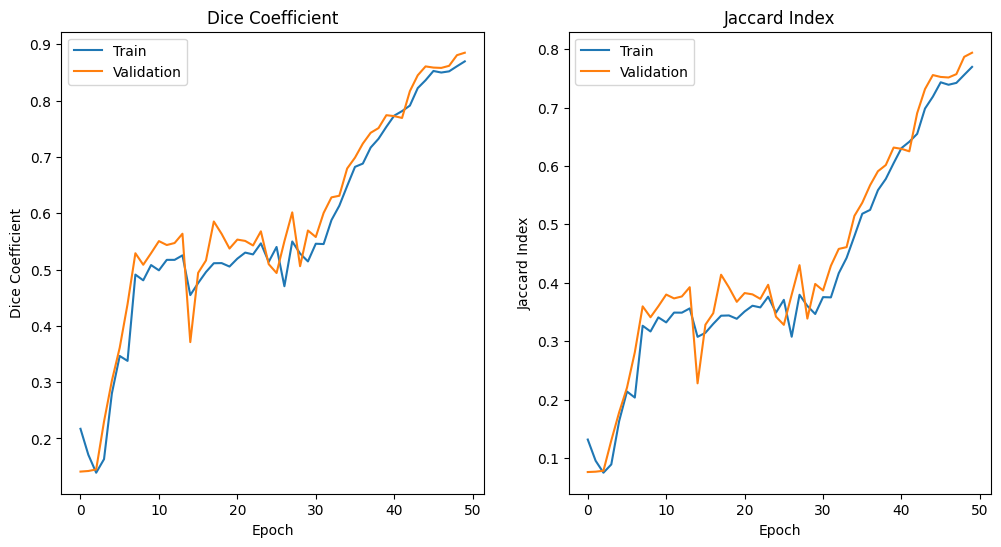

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Additional plots for Dice coefficient and Jaccard index
plt.figure(figsize=(12, 6))

# Plot Dice coefficient values
plt.subplot(1, 2, 1)
plt.plot(history1.history['dice_coef'])
plt.plot(history1.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Jaccard index values
plt.subplot(1, 2, 2)
plt.plot(history1.history['jaccard_index'])
plt.plot(history1.history['val_jaccard_index'])
plt.title('Jaccard Index')
plt.ylabel('Jaccard Index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 778ms/step


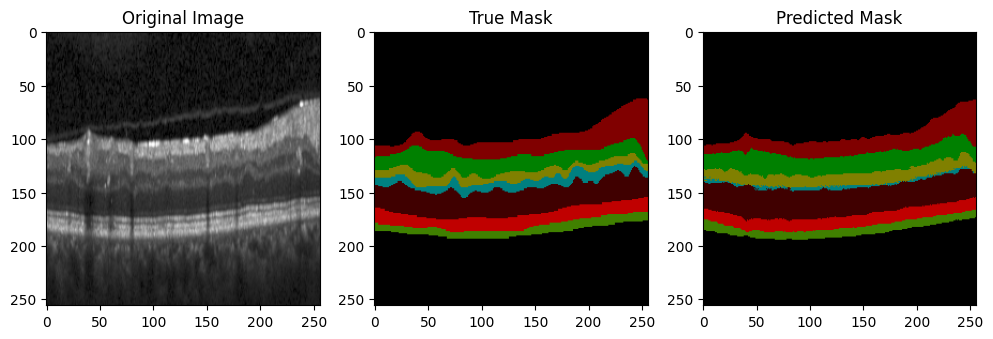

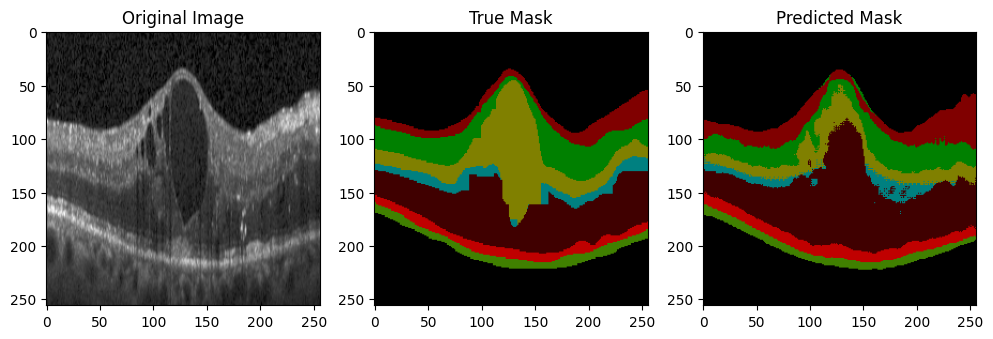

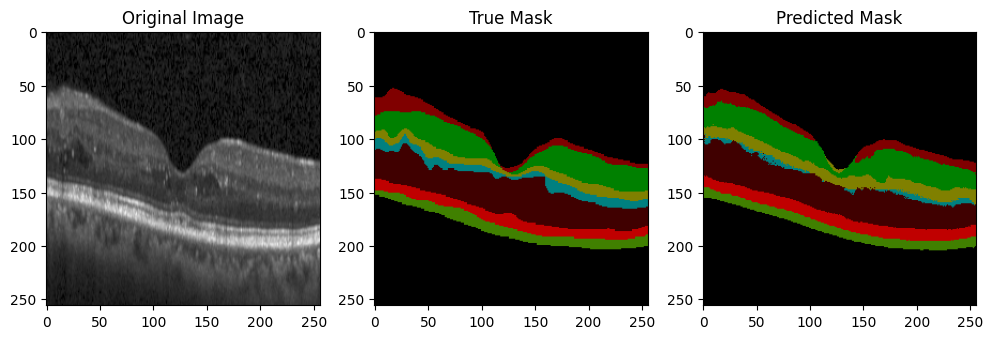

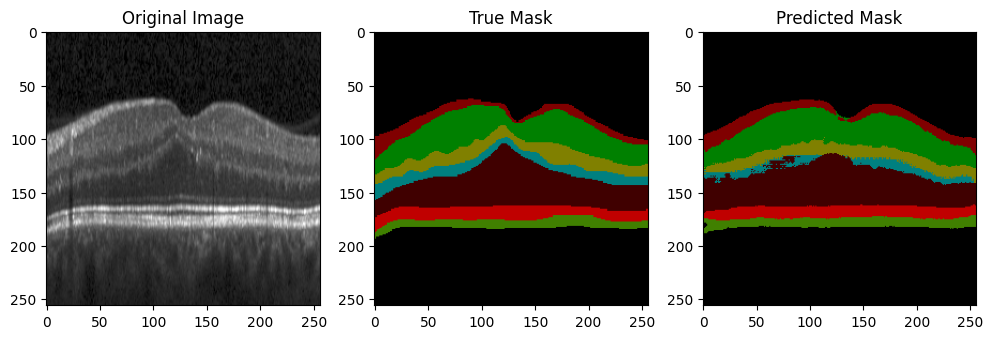

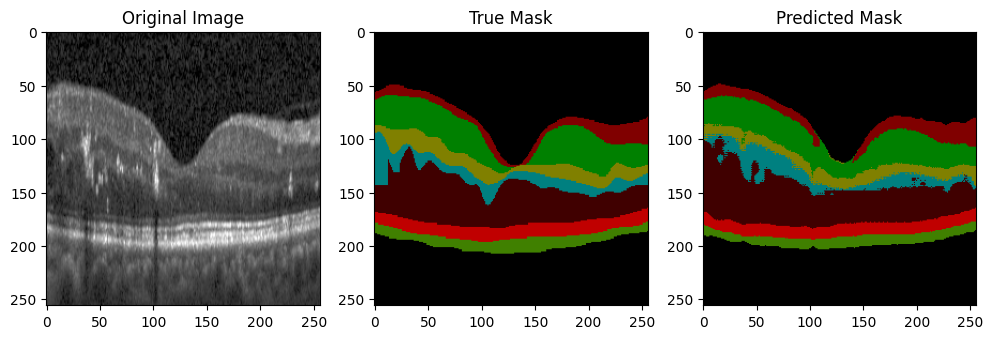

In [ ]:

# Define color map for visualization
COLOR_MAP = np.array([
    [0, 0, 0],        # Background (class 0) - black
    [128, 0, 0],      # Class 1 - maroon
    [0, 128, 0],      # Class 2 - green
    [128, 128, 0],    # Class 3 - olive
    [0, 128, 128],    # Class 4 - teal
    [64, 0, 0],       # Class 5 - dark red
    [192, 0, 0],      # Class 6 - red
    [64, 128, 0]      # Class 7 - olive
])

# Function to apply color map to predicted labels
def apply_color_map(mask, color_map=COLOR_MAP):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Create an empty RGB image
    for class_idx, color in enumerate(color_map):
        color_mask[mask == class_idx] = color
    return color_mask

# Predict on validation data
preds = model.predict(X_val)

# Convert predicted one-hot encoded masks to class labels
predicted_labels = np.argmax(preds, axis=-1)

# Visualize actual and predicted masks
def visualize_segmentation(image, true_mask, pred_mask, idx):
    true_colored = apply_color_map(np.argmax(true_mask, axis=-1))  # Convert one-hot true mask to color map
    pred_colored = apply_color_map(pred_mask)  # Apply color map to predicted mask

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_colored)
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_colored)
    plt.title('Predicted Mask')

    plt.show()

# Visualize a few examples
for i in range(5):  # Visualize the first 5 predictions
    visualize_segmentation(X_val[i], y_val[i], predicted_labels[i], i)


In [ ]:

# Save the model architecture to a .keras file
model.save("unet_model.keras", save_format='keras')

print("Model architecture and weights saved successfully.")

Model architecture and weights saved successfully.


# FCN

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load images and masks
images = np.load(r"/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_images.npy")
masks = np.load(r"/kaggle/input/retinal-layer-segmentation/Images_npy_files/resized_labeledimages.npy")

# Normalize images to [0, 1] and convert to float32
images = np.clip(images, 0, 255).astype(np.float32) / 255.0

# Resize images to the target shape (256, 256)
def resize_images(images, target_size=(256, 256)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Resize the loaded images
images_resized = resize_images(images)

# Resize masks to ensure they are the same size as images
def resize_masks(masks, target_size=(256, 256)):
    resized_masks = []
    for mask in masks:
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_masks.append(resized_mask)
    return np.array(resized_masks)

masks_resized = resize_masks(masks)

# Convert masks to one-hot encoding
num_classes = 8  # Adjust based on your dataset
masks_categorical = tf.keras.utils.to_categorical(masks_resized, num_classes=num_classes)

# Ensure images are in shape (num_samples, height, width, 1)
images_resized = np.expand_dims(images_resized, axis=-1)  # Now shape is (num_samples, height, width, 1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_resized, masks_categorical, test_size=0.2, random_state=42)

# Define the Fully Convolutional Network (FCN) model
def fcn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Upsampling)
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)  # Softmax for multi-class

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Dice and Jaccard coefficients
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())

# Custom loss function
def customized_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_coef(y_true, y_pred))

# Initialize and compile the FCN model
input_shape = (256, 256, 1)  # Grayscale input shape
model = fcn_model(input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=customized_loss,
              metrics=['accuracy', dice_coef, jaccard_coef])

# Callbacks for training
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=6, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

# Train the model
history2 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=50,
                    callbacks=[lr_reducer, csv_logger, model_checkpoint, tensorboard])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3880 - dice_coef: 0.1451 - jaccard_coef: 0.0786 - loss: 2.4430 - val_accuracy: 0.6078 - val_dice_coef: 0.4111 - val_jaccard_coef: 0.2587 - val_loss: 2.3530 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5733 - dice_coef: 0.2576 - jaccard_coef: 0.1517 - loss: 2.2861 - val_accuracy: 0.6078 - val_dice_coef: 0.2083 - val_jaccard_coef: 0.1163 - val_loss: 2.0894 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5773 - dice_coef: 0.2798 - jaccard_coef: 0.1648 - loss: 2.0205 - val_accuracy: 0.6078 - val_dice_coef: 0.4177 - val_jaccard_coef: 0.2640 - val_loss: 1.6236 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5760 - dice_coef: 0.4503 - jaccard_coef: 0.2918 - loss: 1.6148 - val_accuracy: 0.6078 - val_dice_coef: 0.5221 - val_jaccard_coef: 0.3533 - val_loss: 1.3617 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━

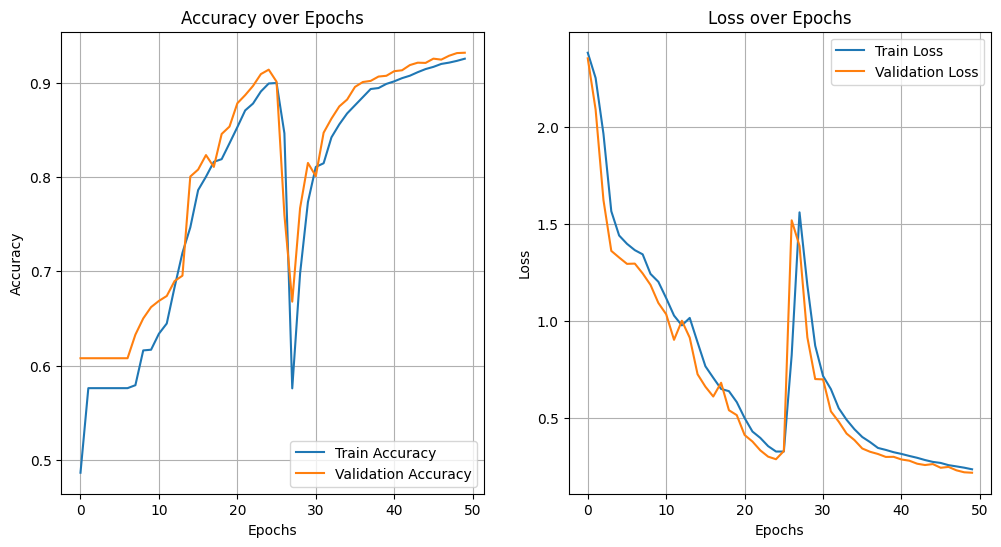

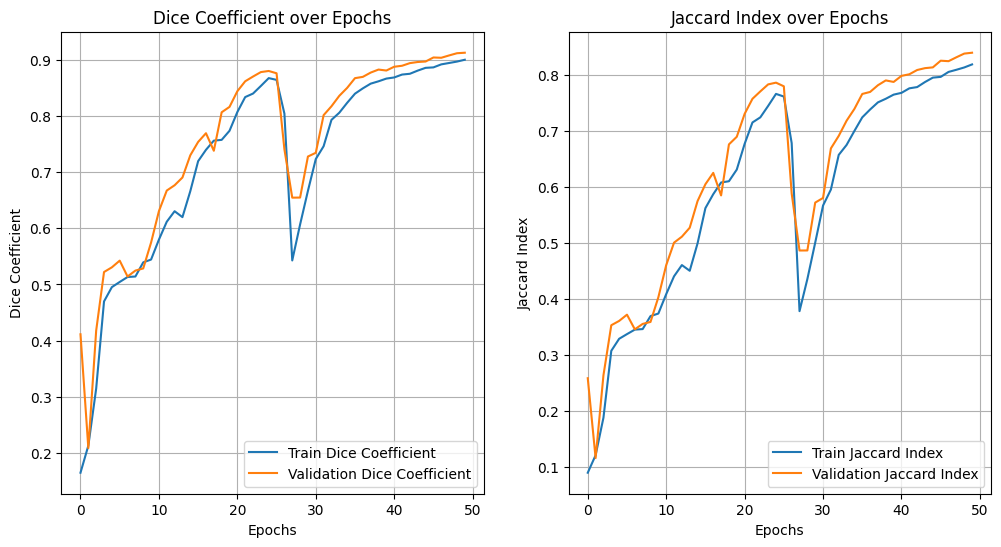

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Dice coefficient plot
    plt.figure(figsize=(12, 6))

    # Dice plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.grid(True)

    # Jaccard Index plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['jaccard_coef'], label='Train Jaccard Index')
    plt.plot(history.history['val_jaccard_coef'], label='Validation Jaccard Index')
    plt.title('Jaccard Index over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Index')
    plt.legend()
    plt.grid(True)

    plt.show()

# Plot the training history for the second model (history2)
plot_training_history(history2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9315 - dice_coef: 0.9115 - jaccard_coef: 0.8374 - loss: 0.2216
Validation Loss: 0.21974243223667145, Validation Accuracy: 0.9318795800209045, Validation Dice Coefficient: 0.9128054976463318, Validation Jaccard Coefficient: 0.8396208882331848
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


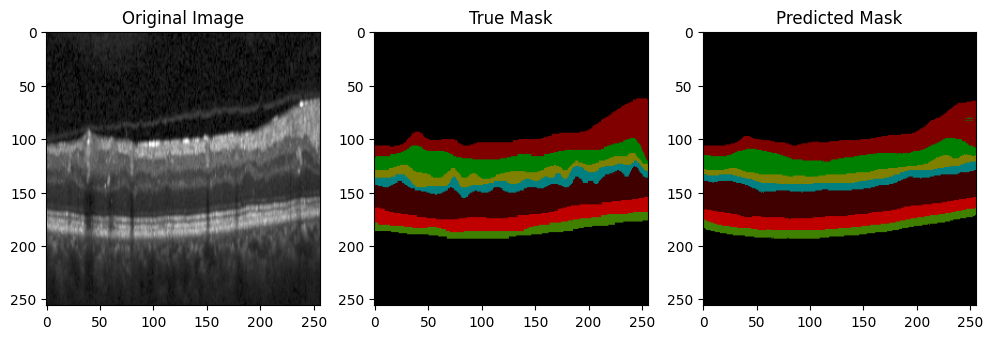

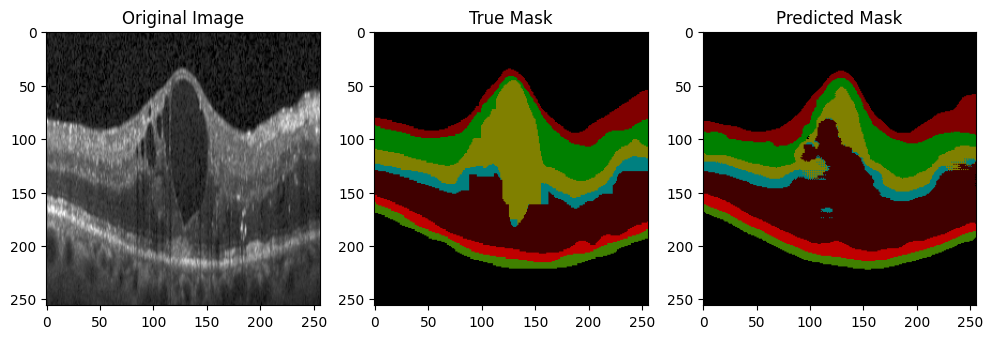

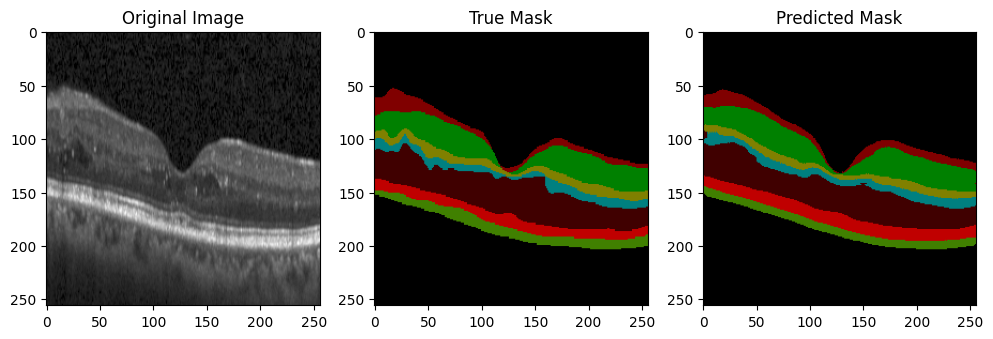

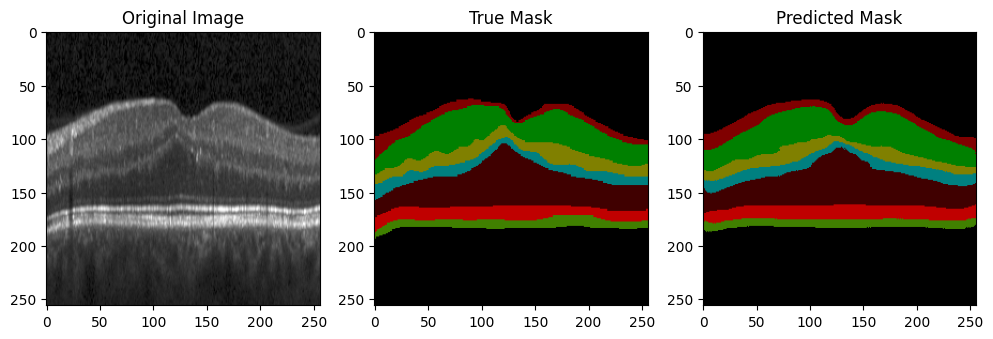

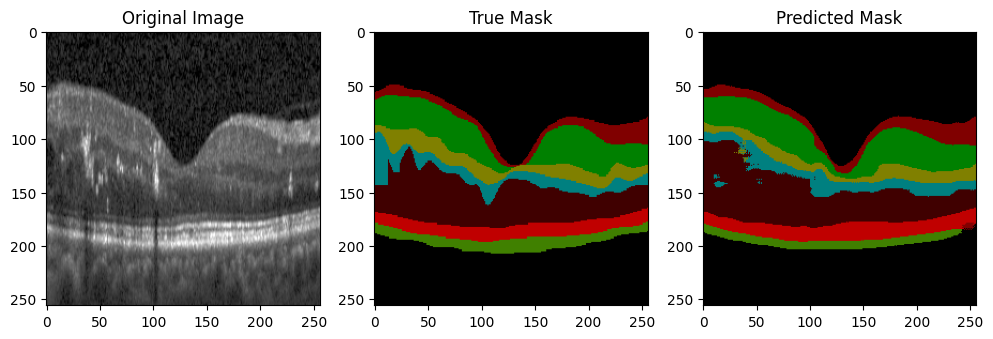

In [ ]:

# Evaluate model performance on the validation set
val_loss, val_accuracy, val_dice, val_jaccard = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Dice Coefficient: {val_dice}, Validation Jaccard Coefficient: {val_jaccard}')

# Define color map for visualization
COLOR_MAP = np.array([
    [0, 0, 0],        # Background (class 0) - black
    [128, 0, 0],      # Class 1 - maroon
    [0, 128, 0],      # Class 2 - green
    [128, 128, 0],    # Class 3 - olive
    [0, 128, 128],    # Class 4 - teal
    [64, 0, 0],       # Class 5 - dark red
    [192, 0, 0],      # Class 6 - red
    [64, 128, 0]      # Class 7 - olive
])

# Function to apply color map to predicted labels
def apply_color_map(mask, color_map=COLOR_MAP):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Create an empty RGB image
    for class_idx, color in enumerate(color_map):
        color_mask[mask == class_idx] = color
    return color_mask

# Predict on validation data
preds = model.predict(X_val)

# Convert predicted one-hot encoded masks to class labels
predicted_labels = np.argmax(preds, axis=-1)

# Visualize actual and predicted masks
def visualize_segmentation(image, true_mask, pred_mask, idx):
    true_colored = apply_color_map(np.argmax(true_mask, axis=-1))  # Convert one-hot true mask to color map
    pred_colored = apply_color_map(pred_mask)  # Apply color map to predicted mask

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_colored)
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_colored)
    plt.title('Predicted Mask')

    plt.show()

# Visualize a few examples
for i in range(5):  # Visualize the first 5 predictions
    visualize_segmentation(X_val[i], y_val[i], predicted_labels[i], i)


In [ ]:

# Save the model architecture to a .keras file
model.save("FCN_model.keras", save_format='keras')

print("Model architecture and weights saved successfully.")

Model architecture and weights saved successfully.
